In [79]:


# Import all libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from datetime import datetime

print("=== COMPLETE SPARK MBA NOTEBOOK ===")
print("Dataset: online_retail_II.xlsx (2 sheets)")
print("Expected records: ~1.1 million")

=== COMPLETE SPARK MBA NOTEBOOK ===
Dataset: online_retail_II.xlsx (2 sheets)
Expected records: ~1.1 million


In [80]:
!pip list

Package                 Version
----------------------- -----------
aiohappyeyeballs        2.6.1
aiohttp                 3.12.15
aiosignal               1.4.0
asttokens               3.0.0
attrs                   25.3.0
certifi                 2025.8.3
charset-normalizer      3.4.3
click                   8.2.1
cloudpickle             3.1.1
comm                    0.2.3
complete                0.0.1
contourpy               1.3.3
cycler                  0.12.1
dask                    2025.9.1
dask-glm                0.3.2
dask-ml                 2025.1.0
debugpy                 1.8.16
decorator               5.2.1
distributed             2025.9.1
et_xmlfile              2.0.0
exceptiongroup          1.3.0
executing               2.2.1
fonttools               4.59.2
frozenlist              1.7.0
fsspec                  2025.9.0
geopandas               1.1.1
idna                    3.10
importlib_metadata      8.7.0
ipykernel               6.30.1
ipython                 9.5.0
ipython_pyg

In [81]:
# Cell 2: Initialize Spark
def initialize_spark():
    """Initialize Spark session for notebook environment"""
    print("🔄 INITIALIZING SPARK SESSION")
    print("-" * 40)
    
    spark = SparkSession.builder \
        .appName("MarketBasketAnalysis") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()
    
    spark.sparkContext.setLogLevel("WARN")
    print("✓ Spark session initialized")
    return spark

# Initialize Spark
spark = initialize_spark()

🔄 INITIALIZING SPARK SESSION
----------------------------------------
✓ Spark session initialized


In [82]:
# Cell 3: Load CSV File
def load_csv_data(file_path):
    """Load data from online_retail_II.csv"""
    print("📂 LOADING CSV FILE")
    print("-" * 40)
    
    # Define schema for better performance
    custom_schema = StructType([
        StructField("Invoice", StringType(), True),
        StructField("StockCode", StringType(), True),
        StructField("Description", StringType(), True),
        StructField("Quantity", IntegerType(), True),
        StructField("InvoiceDate", TimestampType(), True),
        StructField("Price", DoubleType(), True),
        StructField("Customer ID", IntegerType(), True),
        StructField("Country", StringType(), True)
    ])
    
    # Load CSV with inferred schema (more flexible)
    print("Loading online_retail_II.csv...")
    df_raw = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .csv(file_path)
    
    # Rename columns to match our expected format
    df_raw = df_raw \
        .withColumnRenamed("Invoice", "InvoiceNo") \
        .withColumnRenamed("Price", "UnitPrice") \
        .withColumnRenamed("Customer ID", "CustomerID")
    
    original_count = df_raw.count()
    print(f"✓ Records loaded: {original_count:,}")
    
    # Show basic info
    print(f"✓ Columns: {', '.join(df_raw.columns)}")
    
    # Show date range
    date_range = df_raw.agg(
        min("InvoiceDate").alias("min_date"),
        max("InvoiceDate").alias("max_date")
    ).collect()[0]
    
    print(f"✓ Date range: {date_range['min_date']} to {date_range['max_date']}")
    
    return df_raw

# Load the data
file_path = "online_retail_II.csv"  # Make sure this file is in your notebook directory
df_raw = load_csv_data(file_path)

# Show sample data
print("\n📊 SAMPLE DATA:")
df_raw.show(5)
print(f"Total records: {df_raw.count():,}")

📂 LOADING CSV FILE
----------------------------------------
Loading online_retail_II.csv...


✓ Records loaded: 1,067,371
✓ Columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country


✓ Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00

📊 SAMPLE DATA:
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00|     6.95|   13085.0|United Kingdom|
|   489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00|     6.75|   13085.0|United Kingdom|
|   489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00|     6.75|   13085.0|United Kingdom|
|   489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|      2.1|   13085.0|United Kingdom|
|   489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00|     1.25|   13085.0|United Kingdom|
+---------+---------+--------------------+--------+------------

[Stage 1143:>                                                       (0 + 2) / 2]

Total records: 1,067,371


In [83]:
# Cell 4: Data Cleaning Pipeline
def comprehensive_cleaning(df_raw):
    """Complete data cleaning pipeline"""
    print("\n🧹 COMPREHENSIVE DATA CLEANING")
    print("=" * 50)
    
    original_count = df_raw.count()
    print(f"Starting with {original_count:,} records")
    
    # Data Quality Analysis
    print("\n4.1 DATA QUALITY ANALYSIS")
    print("-" * 40)
    
    # Missing values
    missing_analysis = df_raw.select([
        count(when(isnull(c), c)).alias(c) for c in df_raw.columns
    ]).collect()[0]
    
    print("Missing values:")
    for col_name in df_raw.columns:
        missing_count = missing_analysis[col_name]
        if missing_count > 0:
            print(f"  {col_name}: {missing_count:,} ({missing_count/original_count*100:.2f}%)")
    
    # Data issues
    data_issues = df_raw.agg(
        count(when(col("Quantity") <= 0, True)).alias("invalid_quantity"),
        count(when(col("UnitPrice") <= 0, True)).alias("invalid_price"),
        count(when(col("InvoiceNo").startswith("C"), True)).alias("cancelled_invoices")
    ).collect()[0]
    
    print("\nData quality issues:")
    print(f"  Invalid quantities: {data_issues['invalid_quantity']:,}")
    print(f"  Invalid prices: {data_issues['invalid_price']:,}")
    print(f"  Cancelled invoices: {data_issues['cancelled_invoices']:,}")
    
    # Cleaning Steps
    print("\n4.2 APPLYING CLEANING RULES")
    print("-" * 40)
    
    df_clean = df_raw
    
    # Step 1: Remove cancelled invoices
    df_clean = df_clean.filter(~col("InvoiceNo").startswith("C"))
    cancelled_count = original_count - df_clean.count()
    print(f"✓ Removed cancellations: {cancelled_count:,} records")
    
    # Step 2: Remove invalid quantities and prices
    df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))
    invalid_count = original_count - cancelled_count - df_clean.count()
    print(f"✓ Removed invalid data: {invalid_count:,} records")
    
    # Step 3: Handle missing values
    df_clean = df_clean.filter(col("CustomerID").isNotNull() & col("Description").isNotNull())
    missing_count = original_count - cancelled_count - invalid_count - df_clean.count()
    print(f"✓ Removed missing values: {missing_count:,} records")
    
    # Step 4: Standardize descriptions
    df_clean = df_clean.withColumn("Description", upper(trim(col("Description"))))
    print(f"✓ Standardized descriptions")
    
    # Step 5: Remove POST/non-product items
    non_product_keywords = ["POST", "POSTAGE", "CARRIAGE", "DISCOUNT", "FEE", "CHARGE", "ADJUST", "BANK", "CREDIT", "GIFT"]
    condition = ~col("Description").rlike("|".join(non_product_keywords))
    df_clean = df_clean.filter(condition)
    non_product_count = original_count - cancelled_count - invalid_count - missing_count - df_clean.count()
    print(f"✓ Removed non-product items: {non_product_count:,} records")
    
    # Step 6: Remove duplicates
    initial_count = df_clean.count()
    df_clean = df_clean.dropDuplicates()
    duplicate_count = initial_count - df_clean.count()
    if duplicate_count > 0:
        print(f"✓ Removed duplicates: {duplicate_count:,} records")
    
    # Post-cleaning analysis
    final_count = df_clean.count()
    retention_rate = (final_count / original_count) * 100
    
    print(f"\n4.3 CLEANING RESULTS")
    print("-" * 40)
    print(f"Original records: {original_count:,}")
    print(f"Cleaned records: {final_count:,}")
    print(f"Records removed: {original_count - final_count:,}")
    print(f"Retention rate: {retention_rate:.2f}%")
    
    # Key metrics
    metrics = df_clean.agg(
        countDistinct("InvoiceNo").alias("transactions"),
        countDistinct("StockCode").alias("products"),
        countDistinct("CustomerID").alias("customers"),
        mean("Quantity").alias("avg_quantity"),
        mean("UnitPrice").alias("avg_price"),
        sum("Quantity").alias("total_quantity")
    ).collect()[0]
    
    print(f"\n📊 FINAL METRICS:")
    print(f"  Transactions: {metrics['transactions']:,}")
    print(f"  Products: {metrics['products']:,}")
    print(f"  Customers: {metrics['customers']:,}")
    print(f"  Avg Quantity: {metrics['avg_quantity']:.2f}")
    print(f"  Avg Price: ${metrics['avg_price']:.2f}")
    print(f"  Total Quantity Sold: {metrics['total_quantity']:,}")
    
    return df_clean

# Run cleaning
df_clean = comprehensive_cleaning(df_raw)

# Show cleaned data sample
print("\n✅ CLEANED DATA SAMPLE:")
df_clean.show(5)


🧹 COMPREHENSIVE DATA CLEANING


Starting with 1,067,371 records

4.1 DATA QUALITY ANALYSIS
----------------------------------------


Missing values:
  Description: 4,382 (0.41%)
  CustomerID: 243,007 (22.77%)



Data quality issues:
  Invalid quantities: 22,950
  Invalid prices: 6,207
  Cancelled invoices: 19,494

4.2 APPLYING CLEANING RULES
----------------------------------------


✓ Removed cancellations: 19,494 records


✓ Removed invalid data: 6,207 records


[Stage 1161:>                                                       (0 + 2) / 2]

✓ Removed missing values: 236,121 records
✓ Standardized descriptions


✓ Removed non-product items: 19,475 records


[Stage 1172:>                                                       (0 + 2) / 2]

✓ Removed duplicates: 25,559 records



4.3 CLEANING RESULTS
----------------------------------------
Original records: 1,067,371
Cleaned records: 760,515
Records removed: 306,856
Retention rate: 71.25%



📊 FINAL METRICS:
  Transactions: 36,722
  Products: 4,503
  Customers: 5,866
  Avg Quantity: 13.52
  Avg Price: $3.12
  Total Quantity Sold: 10,283,096

✅ CLEANED DATA SAMPLE:


[Stage 1194:>                                                       (0 + 1) / 1]

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   489446|    21671|RED SPOT CERAMIC ...|      12|2009-12-01 10:06:00|     1.25|   13758.0|United Kingdom|
|   489594|    21232|STRAWBERRY CERAMI...|      12|2009-12-01 14:19:00|     1.25|   15005.0|United Kingdom|
|   489599|    20711|      JUMBO BAG TOYS|      30|2009-12-01 14:40:00|     1.95|   12758.0|      Portugal|
|   489676|    21864|UNION JACK FLAG P...|     120|2009-12-02 09:49:00|     1.69|   13777.0|United Kingdom|
|   489679|    84371|     BIG PINK POODLE|       1|2009-12-02 10:00:00|    19.95|   16163.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [84]:
# Cell 5: Transaction Preparation
def prepare_transactions_fixed(df_clean):
    """Fixed transaction preparation ensuring unique items"""
    print("\n🛒 PREPARING TRANSACTION DATA (FIXED)")
    print("-" * 40)
    
    # Use collect_set to automatically get unique items
    print("Using collect_set() to ensure unique items in each transaction...")
    transactions_df = df_clean.groupBy("InvoiceNo") \
        .agg(collect_set("StockCode").alias("items")) \
        .filter(size(col("items")) > 0)
    
    # Double-check for duplicates
    transactions_df = transactions_df.withColumn("items", array_distinct(col("items")))
    transactions_df = transactions_df.withColumn("basket_size", size(col("items")))
    
    transaction_count = transactions_df.count()
    print(f"✓ Created {transaction_count:,} transaction baskets")
    
    # Final verification
    final_check = transactions_df.select(
        sum(when(size(col("items")) != size(array_distinct(col("items"))), 1).otherwise(0)).alias("remaining_duplicates")
    ).collect()[0]
    
    if final_check['remaining_duplicates'] == 0:
        print("✅ SUCCESS: All transactions verified to have unique items")
    else:
        print(f"❌ CRITICAL: {final_check['remaining_duplicates']} transactions still have duplicates")
        # Force remove duplicates with UDF as last resort
        from pyspark.sql.functions import udf
        from pyspark.sql.types import ArrayType, StringType
        
        @udf(ArrayType(StringType()))
        def force_unique(items):
            return list(set(items))
        
        transactions_df = transactions_df.withColumn("items", force_unique(col("items")))
        transactions_df = transactions_df.withColumn("basket_size", size(col("items")))
        print("✓ Applied force_unique UDF as last resort")
    
    return transactions_df

# Prepare transactions with the fixed method
transactions_df = prepare_transactions_fixed(df_clean)

# Show final verification
print("\n🔍 FINAL VERIFICATION:")
sample = transactions_df.limit(1).collect()[0]
items = sample['items']
is_unique = len(items) == len(set(items))
print(f"Sample transaction has {len(items)} items, all unique: {is_unique}")
if not is_unique:
    print(f"Duplicates found: {[item for item in items if items.count(item) > 1]}")


🛒 PREPARING TRANSACTION DATA (FIXED)
----------------------------------------
Using collect_set() to ensure unique items in each transaction...


[Stage 1197:>                                                       (0 + 2) / 2]

✓ Created 36,722 transaction baskets


✅ SUCCESS: All transactions verified to have unique items

🔍 FINAL VERIFICATION:


[Stage 1207:============================>                           (1 + 1) / 2]

Sample transaction has 8 items, all unique: True


In [85]:
# Cell 6: Run FP-Growth (Optimized Version)
def run_fp_growth_optimized(transactions_df, min_support=0.01, min_confidence=0.5):
    """Run FP-Growth with optimized parameters to avoid StackOverflow"""
    print(f"\n🔍 RUNNING OPTIMIZED FP-GROWTH ANALYSIS")
    print("-" * 40)
    print(f"Minimum Support: {min_support} (INCREASED)")
    print(f"Minimum Confidence: {min_confidence}")
    
    start_time = time.time()
    
    # Initialize and run FP-Growth with optimized settings
    fp_growth = FPGrowth(
        itemsCol="items", 
        minSupport=min_support,  # Higher support to reduce complexity
        minConfidence=min_confidence,
        numPartitions=10,  # More partitions for better distribution
    )
    
    print("Training FP-Growth model...")
    try:
        model = fp_growth.fit(transactions_df)
        
        # Get results with safe collection
        frequent_itemsets = model.freqItemsets.cache()
        association_rules = model.associationRules.cache()
        
        processing_time = time.time() - start_time
        
        print(f"✓ FP-Growth completed in {processing_time:.2f} seconds")
        
        # Safe counting with try-catch
        try:
            itemset_count = frequent_itemsets.count()
            print(f"✓ Frequent itemsets: {itemset_count:,}")
        except:
            print("⚠ Could not count frequent itemsets")
            itemset_count = 0
            
        try:
            rules_count = association_rules.count()
            print(f"✓ Association rules: {rules_count:,}")
        except:
            print("⚠ Could not count association rules")
            rules_count = 0
        
        return model, frequent_itemsets, association_rules
        
    except Exception as e:
        print(f"❌ FP-Growth failed: {str(e)}")
        print("Trying with even higher support threshold...")
        return None, None, None

# Run optimized FP-Growth
model, frequent_itemsets, association_rules = run_fp_growth_optimized(transactions_df)

if model is None:
    print("\n🔄 TRYING WITH HIGHER SUPPORT THRESHOLD")
    model, frequent_itemsets, association_rules = run_fp_growth_optimized(
        transactions_df, min_support=0.02, min_confidence=0.6
    )

# Testing print
if frequent_itemsets is not None:
    print("TOP 10 FREQUENT ITEMSETS (SORTED BY FREQ)")
    print("-" * 50)

    top10 = frequent_itemsets.orderBy(desc("freq")).limit(10)
    top10.show(truncate=False)
else:
    print("No frequent itemsets generated.")

if association_rules is not None:
    print("TOP 10 FREQUENT ITEMSETS (SORTED BY FREQ)")
    print("-" * 50)

    top10 = association_rules.orderBy(desc("confidence")).limit(10)
    top10.show(truncate=False)
else:
    print("No frequent itemsets generated.")


🔍 RUNNING OPTIMIZED FP-GROWTH ANALYSIS
----------------------------------------
Minimum Support: 0.01 (INCREASED)
Minimum Confidence: 0.5
Training FP-Growth model...


✓ FP-Growth completed in 25.29 seconds


✓ Frequent itemsets: 853


✓ Association rules: 241
TOP 10 FREQUENT ITEMSETS (SORTED BY FREQ)
--------------------------------------------------
+--------+----+
|items   |freq|
+--------+----+
|[85123A]|4895|
|[22423] |3317|
|[85099B]|3260|
|[84879] |2652|
|[20725] |2579|
|[21212] |2508|
|[47566] |2077|
|[22383] |2004|
|[20727] |1997|
|[22382] |1919|
+--------+----+

TOP 10 FREQUENT ITEMSETS (SORTED BY FREQ)
--------------------------------------------------
+--------------+----------+------------------+------------------+--------------------+
|antecedent    |consequent|confidence        |lift              |support             |
+--------------+----------+------------------+------------------+--------------------+
|[22698, 22699]|[22697]   |0.8958677685950414|34.77595792637115 |0.014759544687108545|
|[22698, 22423]|[22697]   |0.8909512761020881|34.585108626871964|0.010456946789390556|
|[22746]       |[22748]   |0.8869565217391304|52.87470355731225 |0.011110505963727466|
|[22698, 22423]|[22699]   |0.8654292343387

In [86]:

def save_results_df_clean(df_clean):
    """Save all df_clean"""
    print("\nSaving DF_CLEAN")
    print("-" * 40)
    
    # Create output directory
    os.makedirs("csv_results", exist_ok=True)
    
    # Save cleaned data
    df_clean.write.mode("overwrite").parquet("csv_results/cleaned_data")
    df_clean.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/cleaned_data_csv")
    
    print("  - cleaned_data/ (Parquet + CSV)")


# Save results
save_results_df_clean(df_clean)


Saving DF_CLEAN
----------------------------------------


[Stage 1252:>                                                       (0 + 1) / 1]

  - cleaned_data/ (Parquet + CSV)


In [87]:
def save_results(df_clean, frequent_itemsets, association_rules, transactions_df):
    """Save all results to files"""
    print("\n💾 SAVING RESULTS")
    print("-" * 40)
    
    # Create output directory
    os.makedirs("csv_results", exist_ok=True)
    
    # Save cleaned data (this should work fine)
    df_clean.write.mode("overwrite").parquet("csv_results/cleaned_data")
    df_clean.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/cleaned_data_csv")
    
    # Save frequent itemsets - FIXED: Convert arrays to strings for CSV
    frequent_itemsets.write.mode("overwrite").parquet("csv_results/frequent_itemsets")
    
    # Convert array columns to string for CSV export
    from pyspark.sql.functions import col, concat_ws
    
    # Convert frequent_itemsets arrays to comma-separated strings
    fi_csv = frequent_itemsets.withColumn("items", concat_ws(", ", col("items")))
    fi_csv.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/frequent_itemsets_csv")
    
    # Save association rules - FIXED: Convert arrays to strings for CSV
    association_rules.write.mode("overwrite").parquet("csv_results/association_rules")
    
    # Convert association_rules arrays to comma-separated strings
    ar_csv = association_rules.withColumn("antecedent", concat_ws(", ", col("antecedent"))) \
                             .withColumn("consequent", concat_ws(", ", col("consequent")))
    ar_csv.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/association_rules_csv")
    
    # Save transaction data
    transactions_df.write.mode("overwrite").parquet("csv_results/transactions")
    
    # Save sample data for quick inspection
    df_clean.limit(10000).write.mode("overwrite").option("header", "true").csv("csv_results/sample_data")
    
    print("✓ All results saved to 'csv_results' folder:")
    print("  - cleaned_data/ (Parquet + CSV)")
    print("  - frequent_itemsets/ (Parquet + CSV)")
    print("  - association_rules/ (Parquet + CSV)")
    print("  - transactions/ (Parquet)")
    print("  - sample_data/ (CSV)")
    
    # Show sample of converted data
    print("\n📊 Sample of converted frequent itemsets (CSV format):")
    fi_csv.show(5, truncate=False)
    
    print("\n📊 Sample of converted association rules (CSV format):")
    ar_csv.show(5, truncate=False)

# Save results with fixed function
save_results(df_clean, frequent_itemsets, association_rules, transactions_df)


💾 SAVING RESULTS
----------------------------------------


✓ All results saved to 'csv_results' folder:
  - cleaned_data/ (Parquet + CSV)
  - frequent_itemsets/ (Parquet + CSV)
  - association_rules/ (Parquet + CSV)
  - transactions/ (Parquet)
  - sample_data/ (CSV)

📊 Sample of converted frequent itemsets (CSV format):
+-----+----+
|items|freq|
+-----+----+
|21155|724 |
|21535|956 |
|22567|431 |
|22602|405 |
|22666|1277|
+-----+----+
only showing top 5 rows


📊 Sample of converted association rules (CSV format):
+------------+----------+------------------+------------------+--------------------+
|antecedent  |consequent|confidence        |lift              |support             |
+------------+----------+------------------+------------------+--------------------+
|22749       |22750     |0.6103059581320451|37.540461297361745|0.010320788628070366|
|22554       |22551     |0.5059252506836828|16.07144208962474 |0.015113555906541037|
|22383, 20725|22384     |0.5543032786885246|11.03258807588076 |0.014732313054844508|
|22383, 20725|20728     |0.509

In [88]:
from pyspark.sql.functions import split, explode, trim, upper, regexp_replace, array_except, col, array, lit, collect_list

# Step 1: Split by comma to separate multiple products
df_clean2 = df_clean.withColumn("DescList", split(col("Description"), ","))

# Step 2: Explode to process each product individually
df_clean2 = df_clean2.withColumn("DescItem", explode(col("DescList")))

# Step 3: Clean each product
df_clean2 = df_clean2.withColumn("DescItem", upper(trim(col("DescItem"))))
df_clean2 = df_clean2.withColumn("DescItem", regexp_replace(col("DescItem"), r"[^A-Z0-9 ]", ""))
df_clean2 = df_clean2.withColumn("DescItem", regexp_replace(col("DescItem"), r"\s+", " "))

# Step 4: Split into tokens and remove stopwords
df_clean2 = df_clean2.withColumn("tokens", split(col("DescItem"), " "))
stopwords_col = array([lit(w) for w in stopwords])
df_clean2 = df_clean2.withColumn("tokens", array_except(col("tokens"), stopwords_col))

# Step 5: Recombine tokens into cleaned product description
df_clean2 = df_clean2.withColumn("DescNorm", regexp_replace(col("tokens").cast("string"), r"[\[\],']", ""))

# Optional: Aggregate back per InvoiceNo for transactions
transactions_df = df_clean2.groupBy("InvoiceNo") \
    .agg(collect_list("DescNorm").alias("items"))

# Check results
print("Sample cleaned descriptions:")
df_clean2.select("DescNorm", "tokens").show(20, truncate=False)

distinct_count = df_clean2.select("DescNorm").distinct().count()
print(f"Number of distinct cleaned descriptions: {distinct_count}")


Sample cleaned descriptions:


+---------------------------------+----------------------------------------+
|DescNorm                         |tokens                                  |
+---------------------------------+----------------------------------------+
|SPOT CERAMIC DRAWER KNOB         |[SPOT, CERAMIC, DRAWER, KNOB]           |
|STRAWBERRY CERAMIC TRINKET       |[STRAWBERRY, CERAMIC, TRINKET]          |
|JUMBO BAG TOYS                   |[JUMBO, BAG, TOYS]                      |
|UNION JACK FLAG PASSPORT COVER   |[UNION, JACK, FLAG, PASSPORT, COVER]    |
|BIG POODLE                       |[BIG, POODLE]                           |
|WRAP                             |[WRAP]                                  |
|SUKI AND FRIENDS                 |[SUKI, AND, FRIENDS]                    |
|BROCADE PURSE                    |[BROCADE, PURSE]                        |
|ARCH BUTTON                      |[ARCH, BUTTON]                          |
|72 SWEETHEART FAIRY CAKE CASES   |[72, SWEETHEART, FAIRY, CAKE, CASES]    |

[Stage 1295:>                                                       (0 + 2) / 2]

Number of distinct cleaned descriptions: 4603


In [89]:
# Testing Cell: Transaction Preparation
def prepare_transactions_test(df_clean):

    print("\nPREPARING TEST MODEL TRANSACTIONS (Description-based)")
    print("-" * 40)

    transactions_df = df_clean.groupBy("InvoiceNo") \
        .agg(collect_set("DescNorm").alias("items")) \
        .filter(size(col("items")) > 0)

    transactions_df = transactions_df.withColumn("items", array_distinct(col("items")))
    transactions_df = transactions_df.withColumn("basket_size", size(col("items")))

    dup_check = transactions_df.select(
        sum(
            when(size(col("items")) != size(array_distinct(col("items"))), 1)
            .otherwise(0)
        ).alias("remaining_duplicates")
    ).collect()[0]["remaining_duplicates"]

    if dup_check == 0:
        print("TEST MODEL transactions verified unique")
    else:
        print(f"Found {dup_check} baskets with duplicates — applying final cleanup")
        from pyspark.sql.functions import udf
        from pyspark.sql.types import ArrayType, StringType

        @udf(ArrayType(StringType()))
        def force_unique(items):
            return list(set(items))

        transactions_df = transactions_df.withColumn("items", force_unique(col("items")))
        transactions_df = transactions_df.withColumn("basket_size", size(col("items")))

    print(f"Created {transactions_df.count():,} test model baskets")
    return transactions_df

test_data = prepare_transactions_test(df_clean2)


PREPARING TEST MODEL TRANSACTIONS (Description-based)
----------------------------------------


TEST MODEL transactions verified unique


[Stage 1315:>                                                       (0 + 2) / 2]

Created 36,722 test model baskets


In [90]:
# Testing Cell: Testing for FP-Growth model output by using Description
def test_fp_growth(test_data, minSupport=0.01, minConfidence=0.5):
    print("\n🚀 Running TEST FP-Growth Model (Using Description)")
    print("-" * 40)

    # 1. Build FP-Growth model
    fp = FPGrowth(
        itemsCol="items",
        minSupport=minSupport,
        minConfidence=minConfidence
    )

    model = fp.fit(test_data)

    # 2. Extract results
    fi_desc = model.freqItemsets
    ar_desc = model.associationRules

    print("\n📌 Frequent Itemsets (Description-based):")
    fi_desc.show(5, truncate=False)

    print("\n📌 Association Rules (Description-based):")
    ar_desc.show(5, truncate=False)

    print("\n🔥 TOP 10 FREQUENT ITEMSETS (SORTED BY FREQ)")
    print("-" * 50)

    fi_top10 = fi_desc.orderBy(desc("freq")).limit(10)
    fi_top10.show(truncate=False)

    print("\n✨ TOP 10 ASSOCIATION RULES (SORTED BY CONFIDENCE)")
    print("-" * 50)

    ar_top10 = ar_desc.orderBy(desc("confidence")).limit(10)
    ar_top10.show(truncate=False)

    return fi_desc, ar_desc

fi_test, ar_test = test_fp_growth(test_data)


🚀 Running TEST FP-Growth Model (Using Description)
----------------------------------------



📌 Frequent Itemsets (Description-based):


+----------------------------------------------------+----+
|items                                               |freq|
+----------------------------------------------------+----+
|[3 BUTTERFLY COOKIE CUTTERS]                        |814 |
|[3 BUTTERFLY COOKIE CUTTERS, 3 HEART COOKIE CUTTERS]|405 |
|[MEMO BOARD COTTAGE DESIGN]                         |655 |
|[JUMBO STORAGE BAG SKULLS]                          |997 |
|[JUMBO STORAGE BAG SKULLS, JUMBO BAG RETROSPOT]     |417 |
+----------------------------------------------------+----+
only showing top 5 rows


📌 Association Rules (Description-based):


+--------------------------------------------+---------------------------+------------------+------------------+--------------------+
|antecedent                                  |consequent                 |confidence        |lift              |support             |
+--------------------------------------------+---------------------------+------------------+------------------+--------------------+
|[LUNCH BAG SPACEBOY DESIGN, LUNCH BAG SKULL]|[LUNCH BAG SUKI DESIGN]    |0.58656330749354  |10.922808203741265|0.01236316104787321 |
|[LUNCH BAG SPACEBOY DESIGN, LUNCH BAG SKULL]|[LUNCH BAG RETROSPOT]      |0.6059431524547804|9.889530864197532 |0.012771635531833778|
|[LUNCH BAG SKULL, LUNCH BAG RETROSPOT]      |[LUNCH BAG SUKI DESIGN]    |0.5525727069351231|10.289845306324336|0.013452426338434726|
|[LUNCH BAG SKULL, LUNCH BAG RETROSPOT]      |[LUNCH BAG SPACEBOY DESIGN]|0.5246085011185683|10.279975121705478|0.012771635531833778|
|[ELEPHANT, ]                                |[BIRTHDAY CARD] 

+-----------------------------+----+
|items                        |freq|
+-----------------------------+----+
|[HANGING HEART TLIGHT HOLDER]|5373|
|[REGENCY CAKESTAND 3 TIER]   |3317|
|[HEART WICKER]               |3120|
|[COLOUR BIRD ORNAMENT]       |2652|
|[JUMBO BAG RETROSPOT]        |2612|
|[LUNCH BAG RETROSPOT]        |2250|
|[PARTY BUNTING]              |2077|
|[LUNCH BAG SKULL]            |1997|
|[LUNCH BAG SUKI DESIGN]      |1972|
|[POPCORN HOLDER]             |1911|
+-----------------------------+----+


✨ TOP 10 ASSOCIATION RULES (SORTED BY CONFIDENCE)
--------------------------------------------------
+--------------------------+---------------+----------+------------------+--------------------+
|antecedent                |consequent     |confidence|lift              |support             |
+--------------------------+---------------+----------+------------------+--------------------+
|[ELEPHANT, ]              |[BIRTHDAY CARD]|1.0       |66.76727272727273 |0.010838189641087

In [91]:
def convert_stockcode_to_description(frequent_itemsets, association_rules, df_clean):

    print("Converting MAIN MODEL results: StockCode to Description")
    print("-" * 60)

    # Lookup table
    lookup = df_clean.select("StockCode", "Description").distinct()

    # -------- Frequent Itemsets --------
    fi_join = frequent_itemsets.withColumn("StockCode", explode("items")).join(lookup, on="StockCode", how="left")

    fi_desc = fi_join.groupby("freq").agg(collect_set("Description").alias("items")).select("items", "freq")

    # -------- Association Rules --------
    ar_join = (
        association_rules.withColumn("StockCode", explode("antecedent"))
               .join(lookup, on="StockCode", how="left")
               .groupby("consequent", "confidence", "lift", "support")
               .agg(collect_set("Description").alias("antecedent_desc"))
    )

    ar_desc = (
        ar_join.withColumn("StockCode", explode("consequent"))
            .join(lookup, on="StockCode", how="left")
            .groupby("antecedent_desc", "confidence", "lift", "support")
            .agg(collect_set("Description").alias("consequent_desc"))
    )

    print("Conversion complete.")
    return fi_desc, ar_desc

fi_desc, ar_desc = convert_stockcode_to_description(
    frequent_itemsets,
    association_rules,
    df_clean
)

Converting MAIN MODEL results: StockCode to Description
------------------------------------------------------------
Conversion complete.


In [92]:
# Cell 7: Analyze Results
def analyze_results(frequent_itemsets, association_rules, transactions_count):
    print("\n📊 ANALYZING RESULTS")
    print("-" * 50)

    # Convert to pandas for easier display
    freq_itemsets_pd = frequent_itemsets.orderBy(desc("freq")).limit(20).toPandas()
    rules_pd = association_rules.orderBy(desc("confidence")).limit(20).toPandas()

    # Calculate support for frequent itemsets
    freq_itemsets_pd['support'] = freq_itemsets_pd['freq'] / transactions_count

    # Display top 10 frequent itemsets
    print("\n🏆 TOP 10 FREQUENT ITEMSETS:")
    for i, row in freq_itemsets_pd.head(10).iterrows():
        items_str = ', '.join(row['items']) if isinstance(row['items'], list) else str(row['items'])
        print(f"  {i+1:2d}. Support: {row['support']:.4f} - Items: {items_str}")

    # Display top 10 association rules
    print(f"\n🎯 TOP 10 ASSOCIATION RULES:")
    if len(rules_pd) > 0:
        for i, row in rules_pd.head(10).iterrows():
            antecedent_str = ', '.join(row['antecedent_desc']) if isinstance(row['antecedent_desc'], list) else str(row['antecedent_desc'])
            consequent_str = ', '.join(row['consequent_desc']) if isinstance(row['consequent_desc'], list) else str(row['consequent_desc'])
            support = row['support'] if 'support' in row else row['freq'] / transactions_count

            print(f"  {i+1:2d}. {antecedent_str} → {consequent_str}")
            print(f"      Confidence: {row['confidence']:.3f}, Support: {support:.4f}")
    else:
        print("  No association rules found.")

    # Rule quality summary
    if len(rules_pd) > 0:
        print(f"\n📈 RULE QUALITY SUMMARY:")
        print(f"  Total rules: {len(rules_pd):,}")
        print(f"  Avg confidence: {rules_pd['confidence'].mean():.3f}")
        print(f"  Max confidence: {rules_pd['confidence'].max():.3f}")
        print(f"  High confidence rules (>0.7): {len(rules_pd[rules_pd['confidence'] > 0.7])}")
        print(f"  Medium confidence rules (>0.5): {len(rules_pd[rules_pd['confidence'] > 0.5])}")
        avg_rule_length = rules_pd['antecedent_desc'].apply(len).mean() + rules_pd['consequent_desc'].apply(len).mean()
        print(f"  Avg rule length: {avg_rule_length:.1f} items")

    return freq_itemsets_pd, rules_pd


# Usage
transaction_count = transactions_df.count()
freq_itemsets_pd, rules_pd = analyze_results(fi_desc, ar_desc, transaction_count)


[Stage 1363:============================>                           (1 + 1) / 2]


📊 ANALYZING RESULTS
--------------------------------------------------


[Stage 1399:>                                                       (0 + 1) / 1]


🏆 TOP 10 FREQUENT ITEMSETS:
   1. Support: 0.1333 - Items: CREAM HANGING HEART T-LIGHT HOLDER, WHITE HANGING HEART T-LIGHT HOLDER
   2. Support: 0.0903 - Items: REGENCY CAKESTAND 3 TIER
   3. Support: 0.0888 - Items: JUMBO BAG RED WHITE SPOTTY, JUMBO BAG RED RETROSPOT, RED RETROSPOT JUMBO BAG
   4. Support: 0.0722 - Items: ASSORTED COLOUR BIRD ORNAMENT
   5. Support: 0.0702 - Items: LUNCH BAG RED SPOTTY, LUNCH BAG RED RETROSPOT
   6. Support: 0.0683 - Items: PACK OF 72 RETRO SPOT CAKE CASES, PACK OF 72 RETROSPOT CAKE CASES
   7. Support: 0.0566 - Items: PARTY BUNTING
   8. Support: 0.0546 - Items: LUNCH BAG SUKI  DESIGN, LUNCHBAG SUKI  DESIGN, LUNCH BAG SUKI DESIGN
   9. Support: 0.0544 - Items: LUNCH BAG  BLACK SKULL.
  10. Support: 0.0523 - Items: LUNCH BAG SPACEBOY DESIGN, LUNCHBAG SPACEBOY DESIGN

🎯 TOP 10 ASSOCIATION RULES:
   1. TEACUP AND SAUCER REGENCY PINK, PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER, TEACUP AND SAUCER REGENCY ROSES → GREEN REGENCY TEACUP 


📈 CREATING VISUALIZATIONS
----------------------------------------


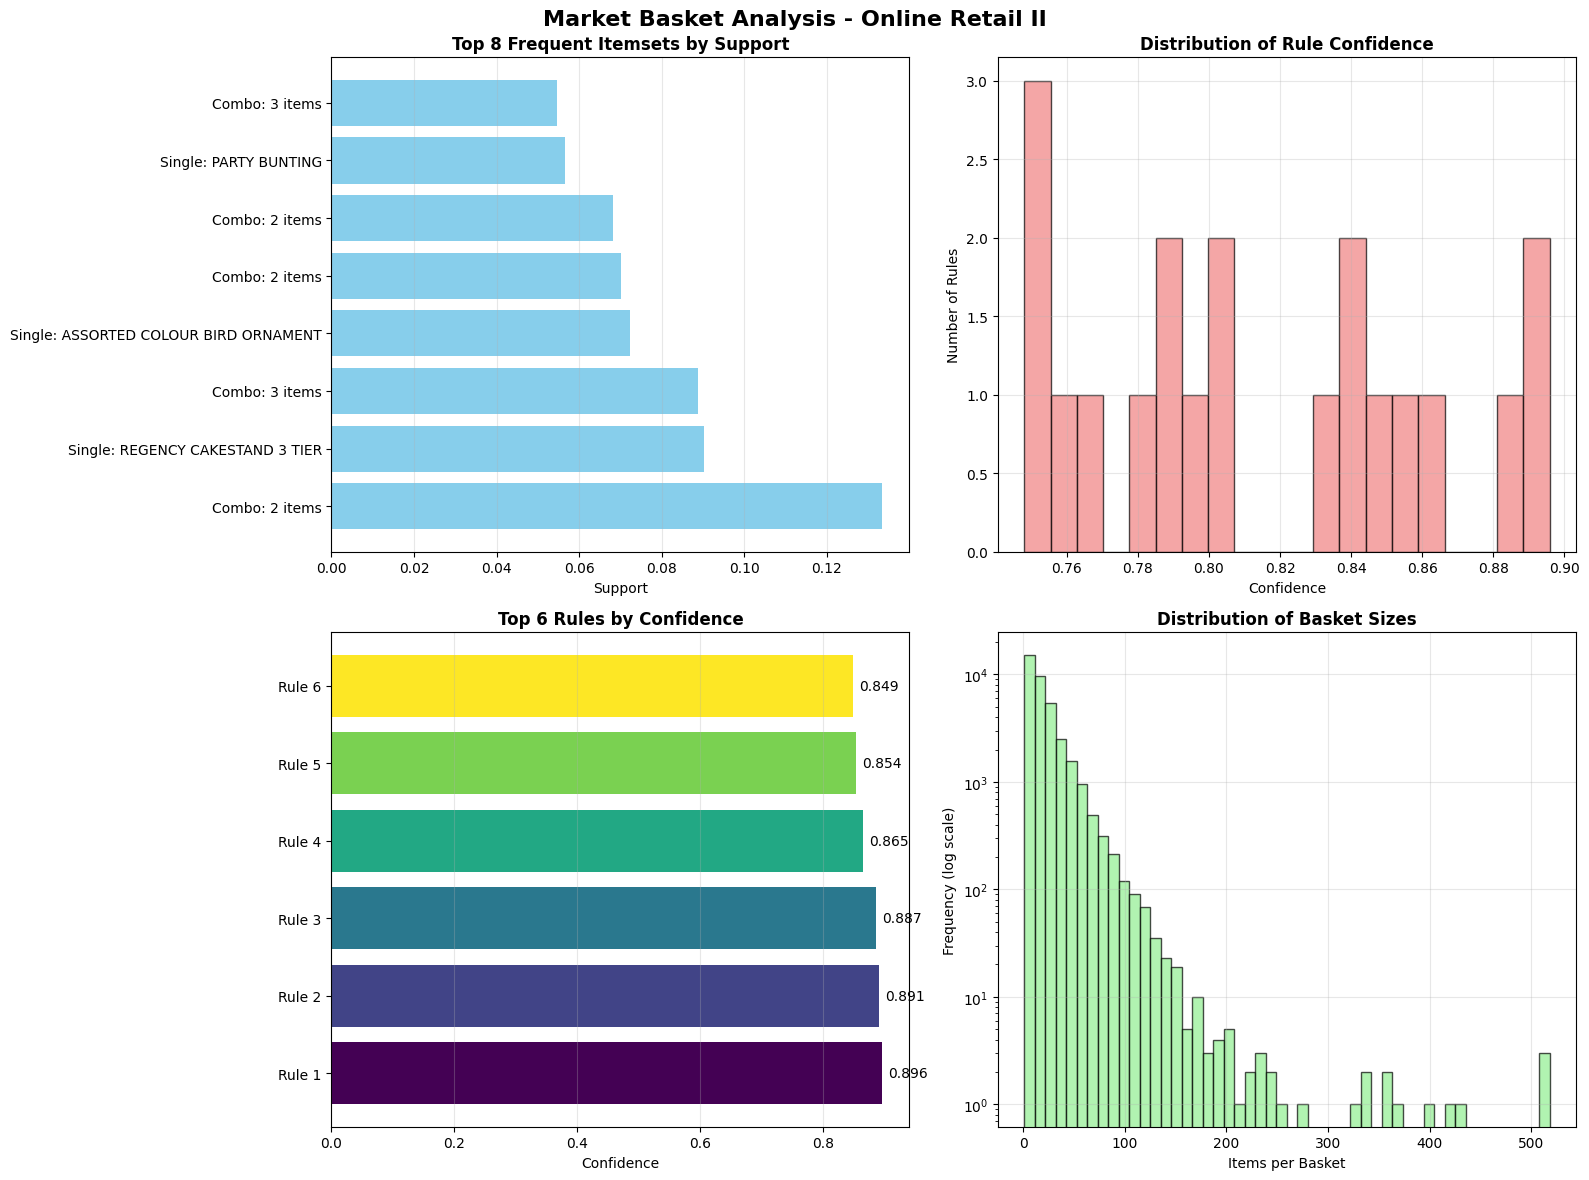

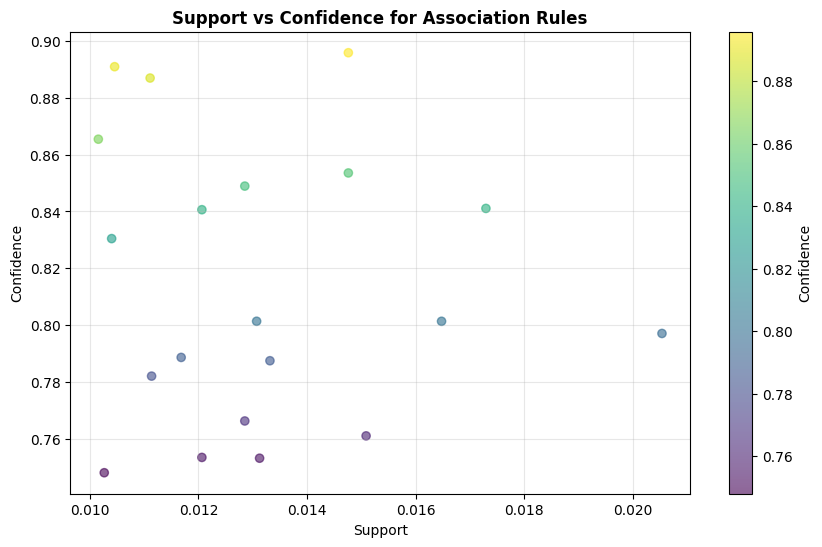

✓ Visualizations created successfully


In [93]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import size, col, array_distinct

def create_visualizations(freq_itemsets_pd, rules_pd, transactions_df):
    """Create visualizations for Market Basket Analysis"""
    print("\n📈 CREATING VISUALIZATIONS")
    print("-" * 40)
    transactions_df = transactions_df.withColumn("items", array_distinct(col("items")))
    transactions_df = transactions_df.withColumn("basket_size", size(col("items")))
    
    transaction_count = transactions_df.count()
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Market Basket Analysis - Online Retail II', fontsize=16, fontweight='bold')
    # Plot 1: Top frequent itemsets by support
    if len(freq_itemsets_pd) > 0:
        top_itemsets = freq_itemsets_pd.head(8)
        labels = []
        for items in top_itemsets['items']:
            if len(items) == 1:
                labels.append(f"Single: {items[0]}")
            else:
                labels.append(f"Combo: {len(items)} items")
        
        axes[0, 0].barh(range(len(top_itemsets)), top_itemsets['support'], color='skyblue')
        axes[0, 0].set_yticks(range(len(top_itemsets)))
        axes[0, 0].set_yticklabels(labels)
        axes[0, 0].set_title('Top 8 Frequent Itemsets by Support', fontweight='bold')
        axes[0, 0].set_xlabel('Support')
        axes[0, 0].grid(axis='x', alpha=0.3)

    # Plot 2: Confidence distribution of rules
    if len(rules_pd) > 0:
        axes[0, 1].hist(rules_pd['confidence'], bins=20, alpha=0.7, edgecolor='black', color='lightcoral')
        axes[0, 1].set_title('Distribution of Rule Confidence', fontweight='bold')
        axes[0, 1].set_xlabel('Confidence')
        axes[0, 1].set_ylabel('Number of Rules')
        axes[0, 1].grid(alpha=0.3)
    # Plot 3: Top rules by confidence
    if len(rules_pd) > 0:
        top_rules = rules_pd.head(6)
        y_pos = np.arange(len(top_rules))
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_rules)))
        
        bars = axes[1, 0].barh(y_pos, top_rules['confidence'], color=colors)
        axes[1, 0].set_yticks(y_pos)
        axes[1, 0].set_yticklabels([f"Rule {i+1}" for i in range(len(top_rules))])
        axes[1, 0].set_title('Top 6 Rules by Confidence', fontweight='bold')
        axes[1, 0].set_xlabel('Confidence')
        axes[1, 0].grid(axis='x', alpha=0.3)
        for i, bar in enumerate(bars):
            width = bar.get_width()
            axes[1, 0].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                            f'{width:.3f}', ha='left', va='center')
    
    # Plot 4: Basket size distribution
    basket_sizes_pd = transactions_df.select("basket_size").toPandas()
    axes[1, 1].hist(basket_sizes_pd['basket_size'], bins=50, alpha=0.7, 
                    edgecolor='black', color='lightgreen')
    axes[1, 1].set_title('Distribution of Basket Sizes', fontweight='bold')
    axes[1, 1].set_xlabel('Items per Basket')
    axes[1, 1].set_ylabel('Frequency (log scale)')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    #scatter: Support vs Confidence
    if len(rules_pd) > 0:
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(rules_pd['support'], rules_pd['confidence'], 
                              alpha=0.6, c=rules_pd['confidence'], cmap='viridis')
        plt.colorbar(scatter, label='Confidence')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Support vs Confidence for Association Rules', fontweight='bold')
        plt.grid(alpha=0.3)
        plt.show()
    
    print("✓ Visualizations created successfully")

# Run the visualizations
create_visualizations(freq_itemsets_pd, rules_pd, transactions_df)


In [94]:
# Cell 9: Save Results
from pyspark.sql.functions import col, concat_ws
import os

def save_results(df_clean, frequent_itemsets, association_rules, transactions_df):
    """Save all results to files"""
    print("\n💾 SAVING RESULTS")
    print("-" * 40)

    os.makedirs("csv_results", exist_ok=True)
    # Save cleaned data
    df_clean.write.mode("overwrite").parquet("csv_results/cleaned_data")
    df_clean.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/cleaned_data_csv")
    # Convert arrays to string for CSV
    frequent_itemsets_csv = frequent_itemsets.withColumn("items", concat_ws(", ", col("items")))
    association_rules_csv = association_rules.withColumn("antecedent", concat_ws(", ", col("antecedent"))) \
                                             .withColumn("consequent", concat_ws(", ", col("consequent")))
    
    # Save frequent itemsets
    frequent_itemsets.write.mode("overwrite").parquet("csv_results/frequent_itemsets")
    frequent_itemsets_csv.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/frequent_itemsets_csv")
    
    # Save association rules
    association_rules.write.mode("overwrite").parquet("csv_results/association_rules")
    association_rules_csv.coalesce(1).write.mode("overwrite").option("header", "true").csv("csv_results/association_rules_csv")

    # Save transaction data

    transactions_df.write.mode("overwrite").parquet("csv_results/transactions")
    # Save sample data for quick inspection
    df_clean.limit(10000).write.mode("overwrite").option("header", "true").csv("csv_results/sample_data")
    
    print("✓ All results saved to 'csv_results' folder:")
    print("  - cleaned_data/ (Parquet + CSV)")
    print("  - frequent_itemsets/ (Parquet + CSV)")
    print("  - association_rules/ (Parquet + CSV)")
    print("  - transactions/ (Parquet)")
    print("  - sample_data/ (CSV)")

# Run the saving function
save_results(df_clean, frequent_itemsets, association_rules, transactions_df)



💾 SAVING RESULTS
----------------------------------------


[Stage 1461:>                                                       (0 + 2) / 2]

✓ All results saved to 'csv_results' folder:
  - cleaned_data/ (Parquet + CSV)
  - frequent_itemsets/ (Parquet + CSV)
  - association_rules/ (Parquet + CSV)
  - transactions/ (Parquet)
  - sample_data/ (CSV)


In [95]:
def generate_business_insights_desc(rules_pd, freq_itemsets_pd, top_n=10):
    """Generate actionable business insights using description-based rules"""
    print("\n💡 BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("=" * 50)
    
    print("🎯 TOP CROSS-SELLING OPPORTUNITIES:")
    print("-" * 40)
    
    for i, row in rules_pd.head(top_n).iterrows():
        antecedent = ', '.join(row['antecedent_desc']) if isinstance(row['antecedent_desc'], list) else str(row['antecedent_desc'])
        consequent = ', '.join(row['consequent_desc']) if isinstance(row['consequent_desc'], list) else str(row['consequent_desc'])
        
        print(f"\n{i+1}. WHEN customers buy: {antecedent}")
        print(f"   THEY ALSO buy: {consequent}")
        print(f"   Confidence: {row['confidence']:.1%}")
        
        # Business recommendation based on confidence
        if row['confidence'] >= 0.7:
            recommendation = "💪 STRONG BUNDLE - Create product bundles and recommend together"
        elif row['confidence'] >= 0.5:
            recommendation = "👍 MODERATE OPPORTUNITY - Cross-sell promotions and suggestions"
        else:
            recommendation = "👀 WEAK ASSOCIATION - Monitor and test with discounts"
        
        print(f"   💡 ACTION: {recommendation}")
    
    print(f"\n📦 POPULAR PRODUCT COMBINATIONS:")
    print("-" * 40)
    for i, row in freq_itemsets_pd.head(5).iterrows():
        items = ', '.join(row['items']) if isinstance(row['items'], list) else str(row['items'])
        if len(row['items']) == 1:
            print(f"  {i+1}. Single popular item: {items} (Support: {row['support']:.2%})")
        else:
            print(f"  {i+1}. Popular combination: {items} (Support: {row['support']:.2%})")
    
    # Summary statistics
    print(f"\n📈 PROJECT SUMMARY:")
    print("-" * 40)
    print(f"  Total association rules found: {len(rules_pd):,}")
    print(f"  High-confidence rules (≥70%): {len(rules_pd[rules_pd['confidence'] >= 0.7])}")
    print(f"  Medium-confidence rules (≥50%): {len(rules_pd[rules_pd['confidence'] >= 0.5])}")
    print(f"  Average rule confidence: {rules_pd['confidence'].mean():.1%}")
# Use your description-based FP-Growth outputs
generate_business_insights_desc(rules_pd, freq_itemsets_pd)


💡 BUSINESS INSIGHTS & RECOMMENDATIONS
🎯 TOP CROSS-SELLING OPPORTUNITIES:
----------------------------------------

1. WHEN customers buy: TEACUP AND SAUCER REGENCY PINK, PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER, TEACUP AND SAUCER REGENCY ROSES
   THEY ALSO buy: GREEN REGENCY TEACUP AND SAUCER, TEACUP AND SAUCER REGENCY GREEN
   Confidence: 89.6%
   💡 ACTION: 💪 STRONG BUNDLE - Create product bundles and recommend together

2. WHEN customers buy: TEACUP AND SAUCER REGENCY PINK, PINK REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER
   THEY ALSO buy: GREEN REGENCY TEACUP AND SAUCER, TEACUP AND SAUCER REGENCY GREEN
   Confidence: 89.1%
   💡 ACTION: 💪 STRONG BUNDLE - Create product bundles and recommend together

3. WHEN customers buy: POPPY'S PLAYHOUSE LIVINGROOM
   THEY ALSO buy: POPPY'S PLAYHOUSE KITCHEN
   Confidence: 88.7%
   💡 ACTION: 💪 STRONG BUNDLE - Create product bundles and recommend together

4. WHEN customers buy: TEACUP AND SAUCER REGENCY PINK, PINK R